In [1]:
# 구글 드라이브 MOUNT
from google.colab import drive
drive.mount('/content/drive')

# github와 연동하고 싶은 폴더로 이동

%cd /content/drive/MyDrive/study_DL/Study_DL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/study_DL/Study_DL


## 흑백화해서 오토인코더 적용

In [2]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_path = '../필요데이터/dacon_breast_cancer/train_imgs/'
mask_path = '../필요데이터/dacon_breast_cancer/train_masks/'

train_name_li = os.listdir(train_path)
mask_name_li = os.listdir(mask_path)

In [4]:
len(train_name_li), len(mask_name_li)

(1000, 58)

In [5]:
width = 0
height = 0

for i in mask_name_li:
  mask_img = cv2.imread(os.path.join(mask_path, i))
  mask_img_shape = mask_img.shape
  width = max(width, mask_img.shape[1])
  height = max(height, mask_img.shape[0])


width, height

(7967, 3462)

In [6]:
x_train = []
y_train = []

for i in mask_name_li:
  train_img = cv2.imread(os.path.join(train_path, i))
  train_img = cv2.resize(train_img, dsize = (700, 300))

  mask_img = cv2.imread(os.path.join(mask_path, i))
  mask_img = cv2.resize(mask_img, dsize = (700, 300))

  gray_train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
  gray_train_mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)

  x_train.append(gray_train_img)
  y_train.append(gray_train_mask_img)

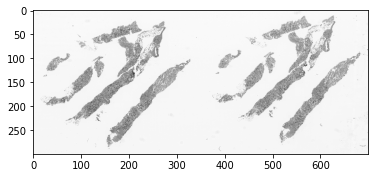

In [17]:
plt.imshow(gray_train_img, cmap = 'gray')

In [7]:
from keras import backend as K
from keras.layers import Flatten, Dense, Reshape, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model

In [8]:
x_train = np.asarray(x_train, dtype = 'float32')/255.
y_train = np.asarray(y_train, dtype = 'float32')/255.

x_train.shape, y_train.shape

((58, 300, 700), (58, 300, 700))

In [9]:
x_train = x_train.reshape(58,300,700,1)
y_train = y_train.reshape(58,300,700,1)
x_train.shape, y_train.shape

((58, 300, 700, 1), (58, 300, 700, 1))

In [10]:
np.save('./x_train.npy', x_train)
np.save('./y_train.npy', y_train)

In [11]:
x_train = np.load('./x_train.npy')
y_train = np.load('./y_train.npy')

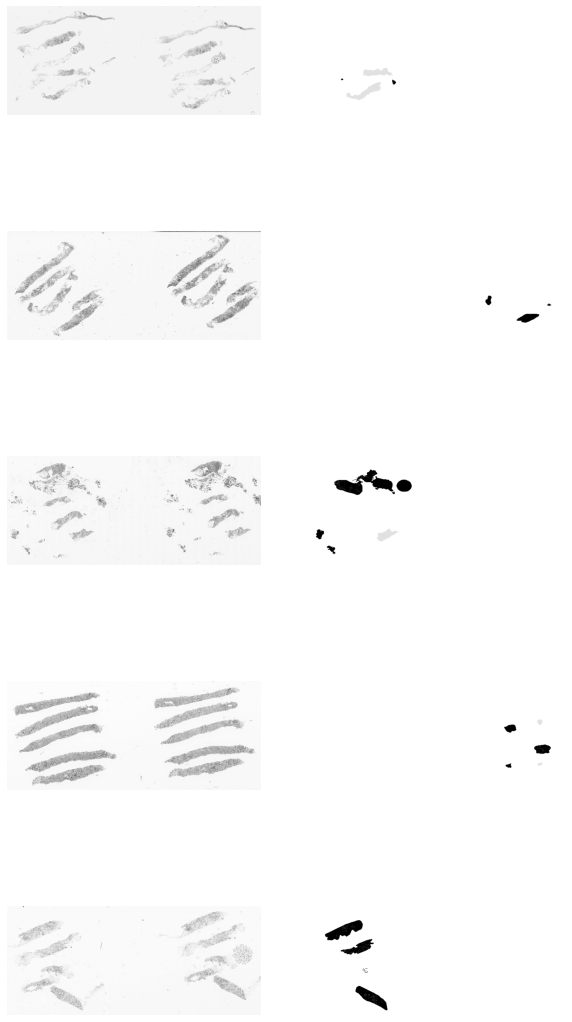

In [46]:

import matplotlib.pyplot as plt

plt.figure(figsize = (10, 20))

for i in range(1, 11, 2):
  ax = plt.subplot(5, 2, i)

  # 원본 데이터
  plt.imshow(x_train[i].reshape((300,700)), cmap = 'gray')
  plt.axis('off')

  # 마스킹 데이터
  ax = plt.subplot(5, 2, i+1)
  plt.imshow(y_train[i].reshape((300,700)), cmap = 'gray')
  plt.axis('off')
plt.show()


In [12]:
input_shape = (300, 700, 1)

In [13]:
batch_size = 32
kernel_size = 3
latent_dim = 16

layer_filters = [
    {"filters":32, "kernel_size":3},
    {"filters":64, "kernel_size":3}, 
    # {"filters":128, "kernel_size":3},
    # {"filters":256, "kernel_size":3},
]

In [14]:
def model():
    input_layer = Input(shape=input_shape) 

    # encoding
    x = input_layer
    for layer_f in layer_filters:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        # x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    # decoding
    for layer_f in layer_filters[::-1]:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        # x = UpSampling2D((2, 2))(x)
        
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(inputs=[input_layer], outputs=[output_layer])
    autoencoder.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return autoencoder

In [15]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 700, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 700, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 700, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 300, 700, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 350, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 350, 64)      0     

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

x_train.shape, y_train.shape

((52, 300, 700, 1), (52, 300, 700, 1))

In [18]:
x_val.shape, y_val.shape

((6, 300, 700, 1), (6, 300, 700, 1))

In [26]:
history = model.fit(x_train, y_train, 
                    epochs = 100,
                    validation_data = (x_val, y_val))

Epoch 1/100
2/2 [==============================] - 23s 5s/step - loss: 0.2598 - mae: 0.4535 - val_loss: 0.2314 - val_mae: 0.4809
Epoch 2/100
2/2 [==============================] - 2s 797ms/step - loss: 0.2078 - mae: 0.3524 - val_loss: 0.2184 - val_mae: 0.4671
Epoch 3/100
2/2 [==============================] - 2s 775ms/step - loss: 0.1693 - mae: 0.3044 - val_loss: 0.1996 - val_mae: 0.4463
Epoch 4/100
2/2 [==============================] - 2s 738ms/step - loss: 0.1481 - mae: 0.2746 - val_loss: 0.1790 - val_mae: 0.4223
Epoch 5/100
2/2 [==============================] - 2s 742ms/step - loss: 0.1372 - mae: 0.2550 - val_loss: 0.1627 - val_mae: 0.4023
Epoch 6/100
2/2 [==============================] - 2s 769ms/step - loss: 0.1290 - mae: 0.2428 - val_loss: 0.1511 - val_mae: 0.3872
Epoch 7/100
2/2 [==============================] - 2s 742ms/step - loss: 0.1212 - mae: 0.2357 - val_loss: 0.1432 - val_mae: 0.3767
Epoch 8/100
2/2 [==============================] - 2s 746ms/step - loss: 0.1142 - mae

In [28]:
x_test = []
for i in train_name_li[:30]:
  if i not in mask_name_li:
    train_img = cv2.imread(os.path.join(train_path, i))
    train_img = cv2.resize(train_img, dsize = (700, 300))

    gray_train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)

    x_test.append(gray_train_img)


In [29]:
x_test = np.asarray(x_test, dtype = 'float32')/255.
x_test.shape

(29, 300, 700)

In [40]:
x_test = x_test.reshape((*x_test.shape, 1))
x_test.shape

(29, 300, 700, 1)

In [41]:
y_pred = model.predict(x_test)
y_pred.shape

1/1 [==============================] - 3s 3s/step


(29, 300, 700, 1)

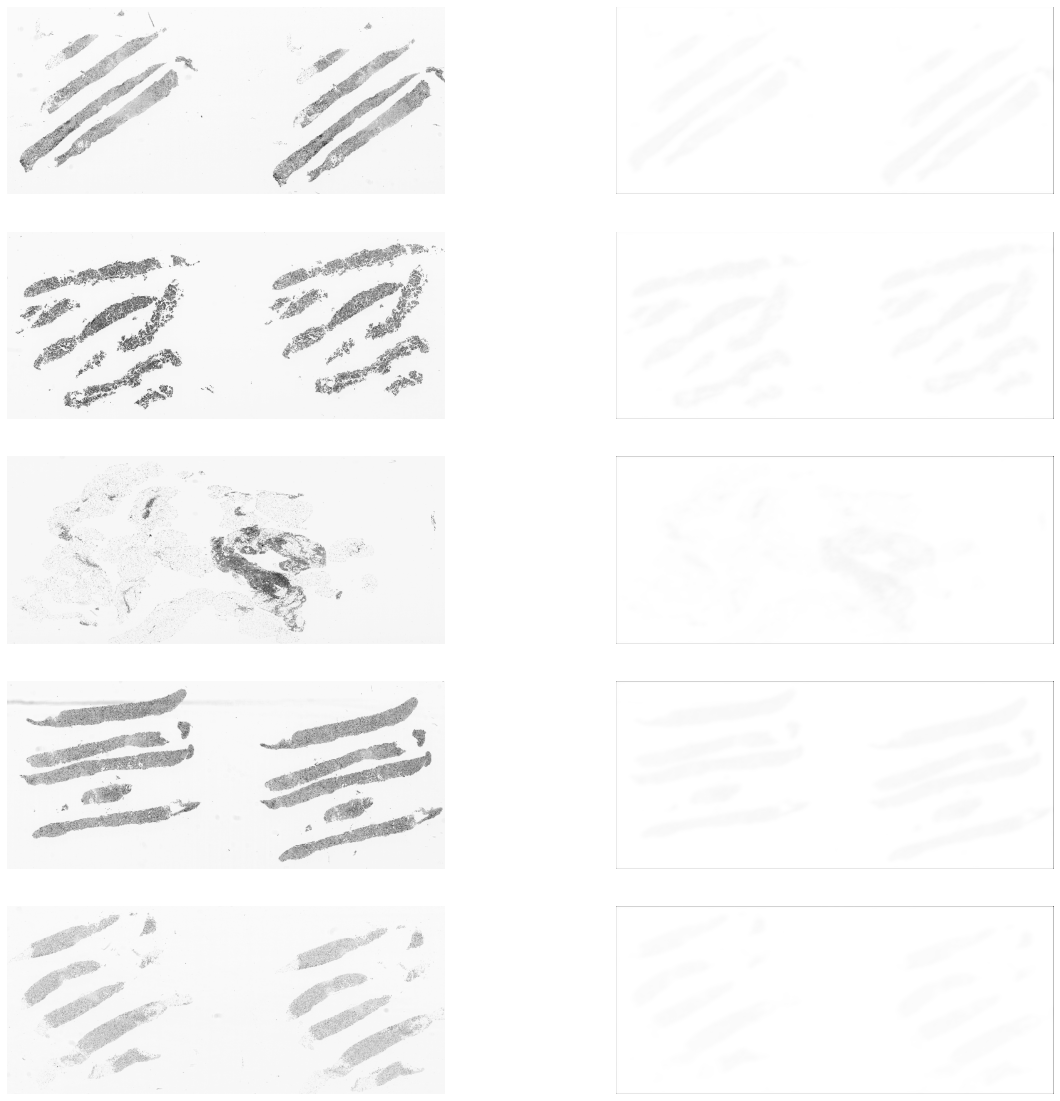

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))

for i in range(1, 11, 2):
  ax = plt.subplot(5, 2, i)

  # 원본 데이터
  plt.imshow(x_test[i].reshape((300,700)), cmap = 'gray')
  plt.axis('off')

  # 마스킹 데이터
  ax = plt.subplot(5, 2, i+1)
  plt.imshow(y_pred[i].reshape((300,700)), cmap = 'gray')
  plt.axis('off')
plt.show()


## 컬러화해서 오토인코더 적용

In [47]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [48]:
train_path = '../필요데이터/dacon_breast_cancer/train_imgs/'
mask_path = '../필요데이터/dacon_breast_cancer/train_masks/'

train_name_li = os.listdir(train_path)
mask_name_li = os.listdir(mask_path)

In [49]:
len(train_name_li), len(mask_name_li)

(1000, 58)

In [ ]:
width = 0
height = 0

for i in mask_name_li:
  mask_img = cv2.imread(os.path.join(mask_path, i))
  mask_img_shape = mask_img.shape
  width = max(width, mask_img.shape[1])
  height = max(height, mask_img.shape[0])


width, height

(7967, 3462)

In [52]:
x_train = []
y_train = []

for i in mask_name_li:
  train_img = cv2.imread(os.path.join(train_path, i))
  train_img = cv2.resize(train_img, dsize = (700, 300))

  mask_img = cv2.imread(os.path.join(mask_path, i))
  mask_img = cv2.resize(mask_img, dsize = (700, 300))

  color_train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
  color_train_mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

  x_train.append(color_train_img)
  y_train.append(color_train_mask_img)

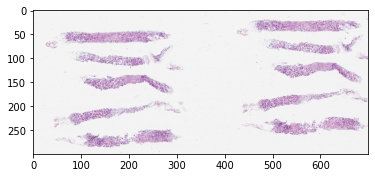

In [53]:
plt.imshow(gray_train_img)

In [54]:
from keras import backend as K
from keras.layers import Flatten, Dense, Reshape, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model

In [55]:
x_train = np.asarray(x_train, dtype = 'float32')/255.
y_train = np.asarray(y_train, dtype = 'float32')/255.

x_train.shape, y_train.shape

((58, 300, 700, 3), (58, 300, 700, 3))

In [ ]:
x_train = x_train.reshape()
y_train = y_train.reshape(58,300,700,1)
x_train.shape, y_train.shape

((58, 300, 700, 1), (58, 300, 700, 1))

In [ ]:
np.save('./x_train.npy', x_train)
np.save('./y_train.npy', y_train)

In [ ]:
x_train = np.load('./x_train.npy')
y_train = np.load('./y_train.npy')

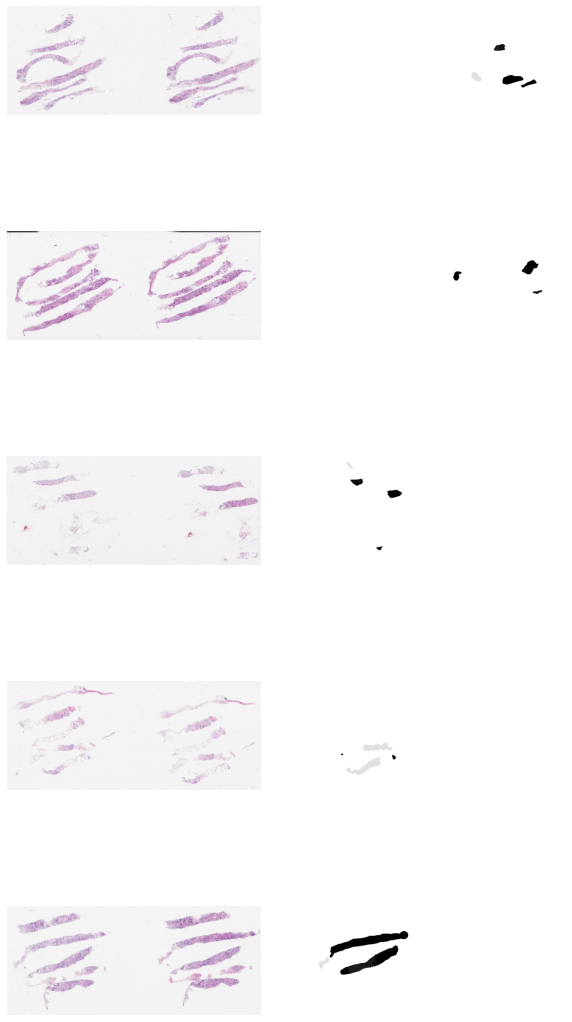

In [57]:

import matplotlib.pyplot as plt

plt.figure(figsize = (10, 20))

for i in range(1, 11, 2):
  ax = plt.subplot(5, 2, i)

  # 원본 데이터
  plt.imshow(x_train[i])
  plt.axis('off')

  # 마스킹 데이터
  ax = plt.subplot(5, 2, i+1)
  plt.imshow(y_train[i])
  plt.axis('off')
plt.show()


In [58]:
input_shape = (300, 700, 3)

In [59]:
batch_size = 32
kernel_size = 3
latent_dim = 16

layer_filters = [
    {"filters":32, "kernel_size":3},
    {"filters":64, "kernel_size":3}, 
    # {"filters":128, "kernel_size":3},
    # {"filters":256, "kernel_size":3},
]

In [62]:
def model():
    input_layer = Input(shape=input_shape) 

    # encoding
    x = input_layer
    for layer_f in layer_filters:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        # x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    # decoding
    for layer_f in layer_filters[::-1]:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        # x = UpSampling2D((2, 2))(x)
        
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(inputs=[input_layer], outputs=[output_layer])
    autoencoder.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return autoencoder

In [63]:
model = model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 700, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 300, 700, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 300, 700, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 300, 700, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 150, 350, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 150, 350, 64)      0   

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

x_train.shape, y_train.shape

((52, 300, 700, 3), (52, 300, 700, 3))

In [66]:
x_val.shape, y_val.shape

((6, 300, 700, 3), (6, 300, 700, 3))

In [67]:
history = model.fit(x_train, y_train, 
                    epochs = 100,
                    validation_data = (x_val, y_val))

Epoch 1/100
2/2 [==============================] - 8s 3s/step - loss: 0.2920 - mae: 0.4997 - val_loss: 0.2367 - val_mae: 0.4859
Epoch 2/100
2/2 [==============================] - 2s 839ms/step - loss: 0.2466 - mae: 0.4402 - val_loss: 0.2189 - val_mae: 0.4669
Epoch 3/100
2/2 [==============================] - 2s 848ms/step - loss: 0.2266 - mae: 0.4031 - val_loss: 0.1999 - val_mae: 0.4454
Epoch 4/100
2/2 [==============================] - 2s 872ms/step - loss: 0.2069 - mae: 0.3750 - val_loss: 0.1785 - val_mae: 0.4195
Epoch 5/100
2/2 [==============================] - 2s 853ms/step - loss: 0.1908 - mae: 0.3527 - val_loss: 0.1576 - val_mae: 0.3920
Epoch 6/100
2/2 [==============================] - 2s 912ms/step - loss: 0.1756 - mae: 0.3335 - val_loss: 0.1411 - val_mae: 0.3682
Epoch 7/100
2/2 [==============================] - 2s 828ms/step - loss: 0.1626 - mae: 0.3163 - val_loss: 0.1275 - val_mae: 0.3466
Epoch 8/100
2/2 [==============================] - 2s 866ms/step - loss: 0.1519 - mae:

In [69]:
x_test = []
for i in train_name_li[:30]:
  if i not in mask_name_li:
    train_img = cv2.imread(os.path.join(train_path, i))
    train_img = cv2.resize(train_img, dsize = (700, 300))

    color_train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

    x_test.append(color_train_img)


In [70]:
x_test = np.asarray(x_test, dtype = 'float32')/255.
x_test.shape

(29, 300, 700, 3)

In [71]:
y_pred = model.predict(x_test)
y_pred.shape

1/1 [==============================] - 1s 1s/step


(29, 300, 700, 3)

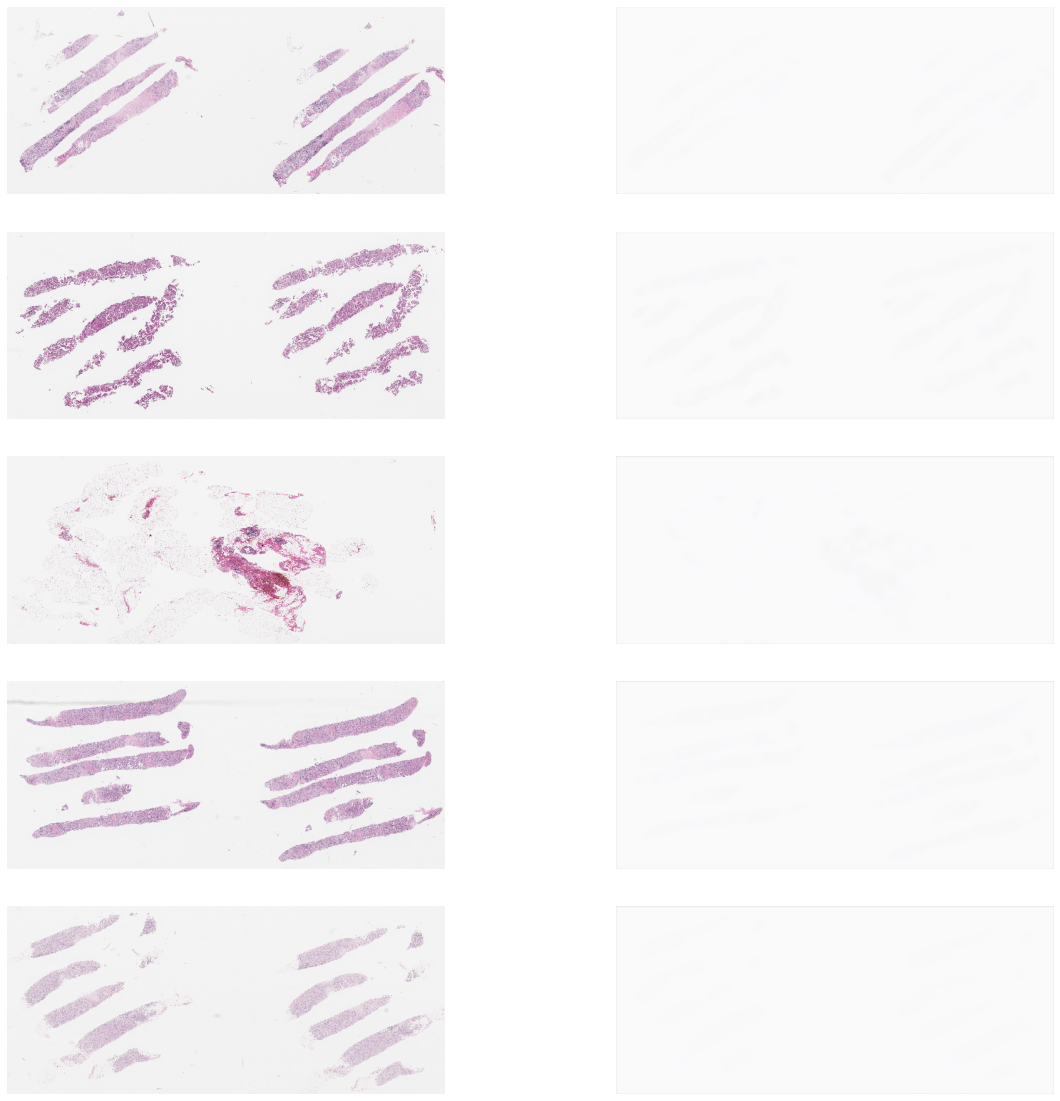

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))

for i in range(1, 11, 2):
  ax = plt.subplot(5, 2, i)

  # 원본 데이터
  plt.imshow(x_test[i])
  plt.axis('off')

  # 마스킹 데이터
  ax = plt.subplot(5, 2, i+1)
  plt.imshow(y_pred[i])
  plt.axis('off')
plt.show()


## 흑백화해서 오토인코더 적용

In [76]:
x_train = []
y_train = []

for i in mask_name_li:
  train_img = cv2.imread(os.path.join(train_path, i))
  train_img = cv2.resize(train_img, dsize = (700, 300))

  mask_img = cv2.imread(os.path.join(mask_path, i))
  mask_img = cv2.resize(mask_img, dsize = (700, 300))

  color_train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
  gray_train_mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)

  x_train.append(color_train_img)
  y_train.append(gray_train_mask_img)

In [77]:
x_train = np.asarray(x_train, dtype = 'float32')/255.
y_train = np.asarray(y_train, dtype = 'float32')/255.

x_train.shape, y_train.shape

((58, 300, 700, 3), (58, 300, 700))

In [78]:
y_train = y_train.reshape(*y_train.shape,1)
x_train.shape, y_train.shape

((58, 300, 700, 3), (58, 300, 700, 1))

In [82]:
np.save('./x_train_color', x_train)
np.save('./y_train_gray', y_train)

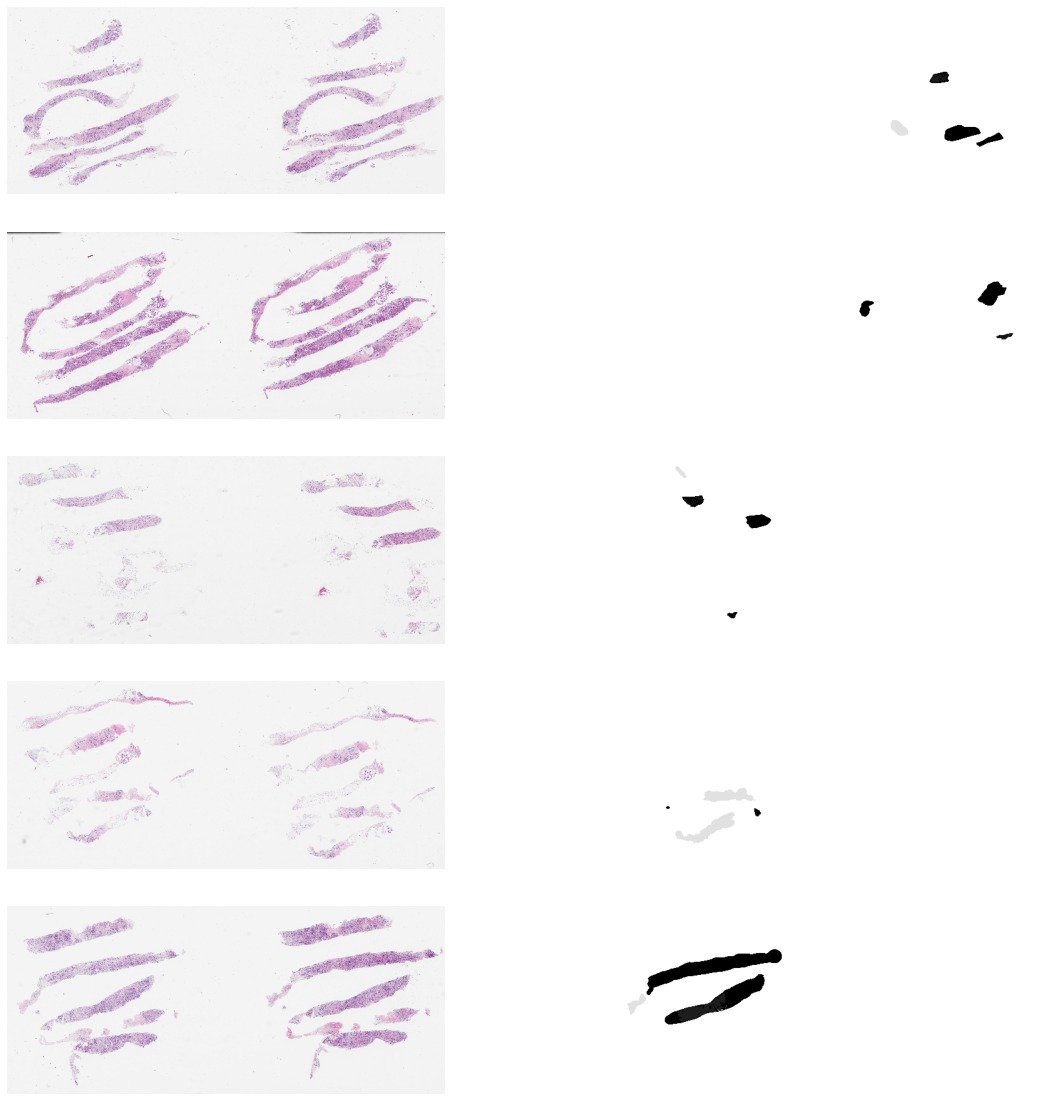

In [80]:

import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))

for i in range(1, 11, 2):
  ax = plt.subplot(5, 2, i)

  # 원본 데이터
  plt.imshow(x_train[i])
  plt.axis('off')

  # 마스킹 데이터
  ax = plt.subplot(5, 2, i+1)
  plt.imshow(y_train[i].reshape((300,700)), cmap = 'gray')
  plt.axis('off')
plt.show()


In [81]:
input_shape = (300, 700, 3)

In [91]:
batch_size = 32
kernel_size = 3
latent_dim = 16

layer_filters = [
    {"filters":32, "kernel_size":3},
    {"filters":64, "kernel_size":3}, 
    # {"filters":128, "kernel_size":3},
    # {"filters":256, "kernel_size":3},
]

In [92]:
def model():
    input_layer = Input(shape=input_shape) 

    # encoding
    x = input_layer
    for layer_f in layer_filters:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        # x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    # decoding
    for layer_f in layer_filters[::-1]:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        # x = UpSampling2D((2, 2))(x)
        
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(inputs=[input_layer], outputs=[output_layer])
    autoencoder.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return autoencoder

In [93]:
model = model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 700, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 300, 700, 32)      896       
                                                                 
 conv2d_23 (Conv2D)          (None, 300, 700, 64)      18496     
                                                                 
 batch_normalization_8 (Batc  (None, 300, 700, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 150, 350, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 150, 350, 64)      0   

In [94]:
from sklearn.model_selection import train_test_split

In [87]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)

x_train.shape, y_train.shape

((52, 300, 700, 3), (52, 300, 700, 1))

In [88]:
x_val.shape, y_val.shape

((6, 300, 700, 3), (6, 300, 700, 1))

In [95]:
history = model.fit(x_train, y_train, 
                    epochs = 100,
                    validation_data = (x_val, y_val))


Epoch 1/100
2/2 [==============================] - 4s 948ms/step - loss: 0.2454 - mae: 0.4446 - val_loss: 0.2337 - val_mae: 0.4832
Epoch 2/100
2/2 [==============================] - 2s 778ms/step - loss: 0.1900 - mae: 0.3392 - val_loss: 0.2195 - val_mae: 0.4682
Epoch 3/100
2/2 [==============================] - 2s 769ms/step - loss: 0.1627 - mae: 0.2946 - val_loss: 0.2056 - val_mae: 0.4530
Epoch 4/100
2/2 [==============================] - 2s 806ms/step - loss: 0.1468 - mae: 0.2722 - val_loss: 0.1899 - val_mae: 0.4351
Epoch 5/100
2/2 [==============================] - 2s 825ms/step - loss: 0.1355 - mae: 0.2579 - val_loss: 0.1743 - val_mae: 0.4165
Epoch 6/100
2/2 [==============================] - 2s 802ms/step - loss: 0.1266 - mae: 0.2465 - val_loss: 0.1604 - val_mae: 0.3990
Epoch 7/100
2/2 [==============================] - 2s 774ms/step - loss: 0.1186 - mae: 0.2391 - val_loss: 0.1474 - val_mae: 0.3818
Epoch 8/100
2/2 [==============================] - 2s 781ms/step - loss: 0.1116 - m

In [96]:
x_test = []
for i in train_name_li[:30]:
  if i not in mask_name_li:
    train_img = cv2.imread(os.path.join(train_path, i))
    train_img = cv2.resize(train_img, dsize = (700, 300))

    color_train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

    x_test.append(color_train_img)


In [97]:
x_test = np.asarray(x_test, dtype = 'float32')/255.
x_test.shape

(29, 300, 700, 3)

In [98]:
y_pred = model.predict(x_test)
y_pred.shape

1/1 [==============================] - 0s 157ms/step


(29, 300, 700, 1)

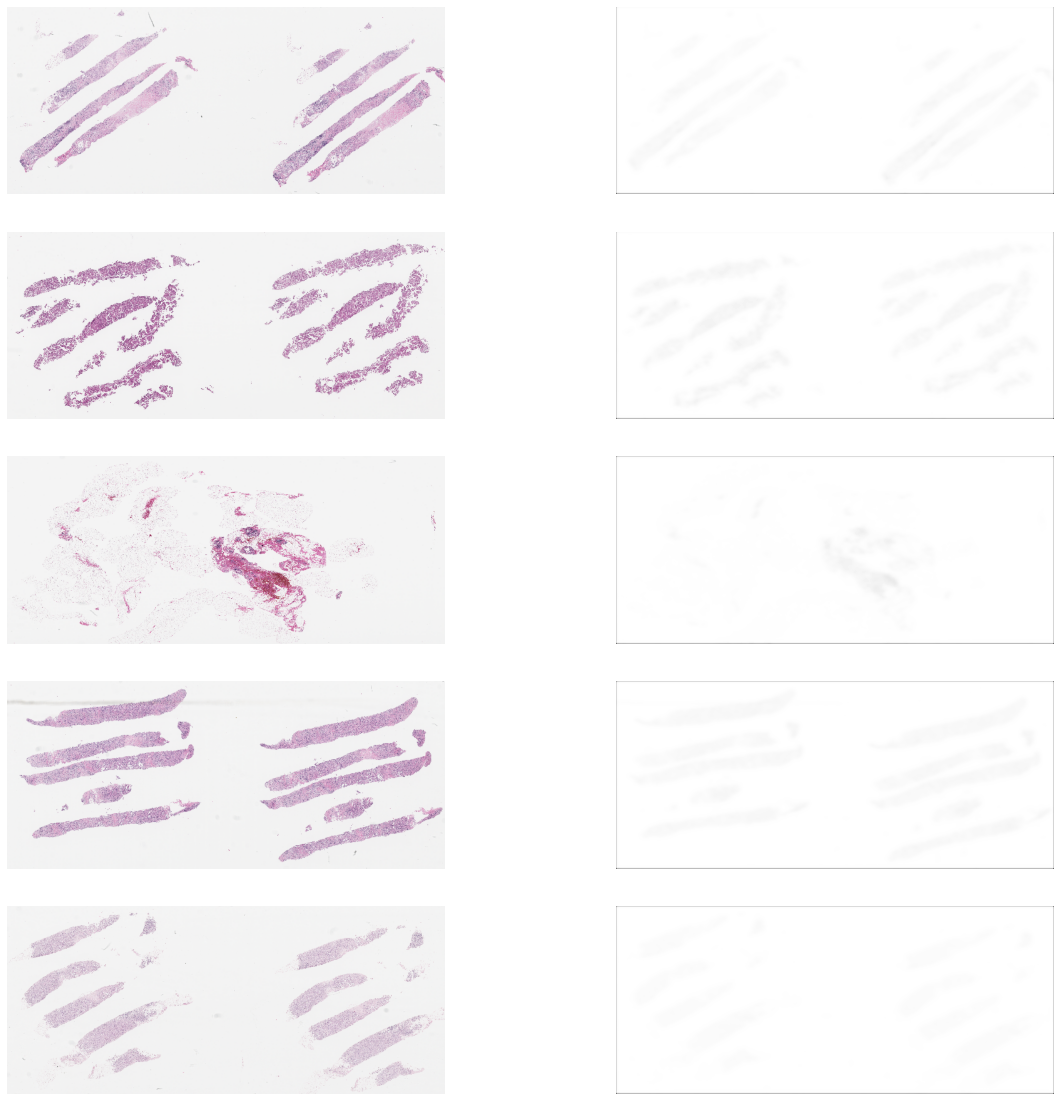

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))

for i in range(1, 11, 2):
  ax = plt.subplot(5, 2, i)

  # 원본 데이터
  plt.imshow(x_test[i])
  plt.axis('off')

  # 마스킹 데이터
  ax = plt.subplot(5, 2, i+1)
  plt.imshow(y_pred[i].reshape((300,700)), cmap = 'gray')
  plt.axis('off')
plt.show()


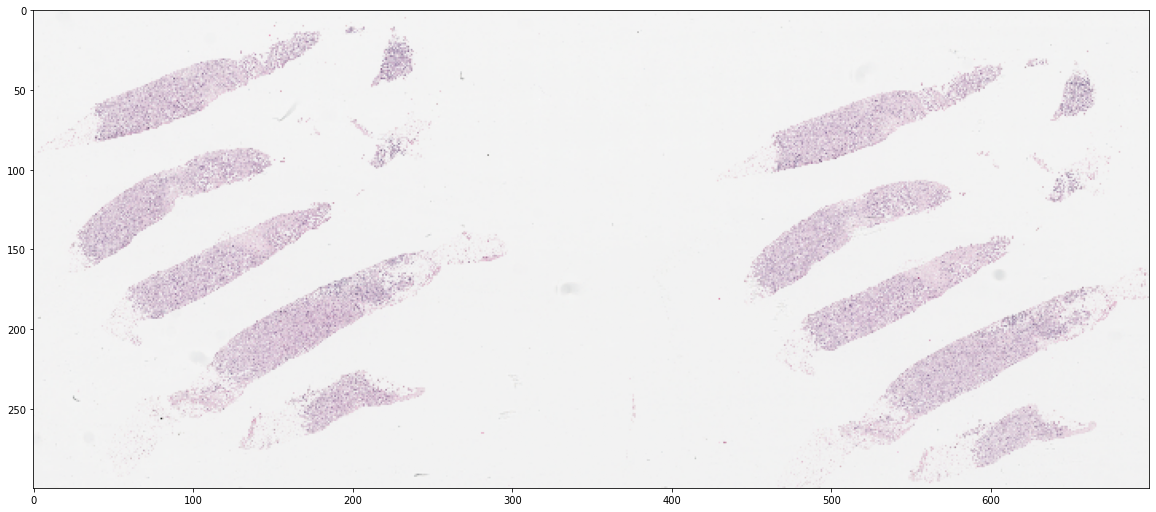

In [101]:
plt.figure(figsize = (20, 20))

# 원본 데이터
plt.imshow(x_test[1])